# Make a dynamic DYNAMAX logo

In [72]:
from fastprogress.fastprogress import progress_bar
import jax.numpy as jnp
import jax.random as jr
from jax.nn import one_hot, softmax, sigmoid
from jax import vmap
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 

tfd = tfp.distributions

In [2]:
# Make a JAX-y color palette
COLORS = ["#6B90CA", # blues
          "#4367B1",
          "#3C5BA9",
          "#29A69A", # greens
          "#1B796C",
          "#186A5C",
          "#C489BC", # purples
          "#903F98",
          "#6A2C91"]

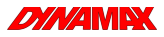

In [4]:
FIGSIZE_PX = jnp.array([2080, 320])
DPI = 1000

# Test that the mask works
fig = plt.figure(figsize=FIGSIZE_PX / DPI)
mask = plt.imread("mask.png")
ax = fig.add_axes((0, 0, 1, 1))
ax.patch.set_color('r')
ax.imshow(mask, aspect="auto")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for sp in ax.spines.values():
    sp.set_visible(False)

plt.savefig("test.png", dpi=1000)

# Break the image down into squares of various sizes

In [110]:
RECT_PX = 80
FIGSIZE_RECT = (FIGSIZE_PX / RECT_PX).astype(int)

patches = []
for i in range(FIGSIZE_RECT[1]):
    for j in range(FIGSIZE_RECT[0]):
        # make a rectangle patch; we'll color it later.
        patches.append(Rectangle((j * RECT_PX, i * RECT_PX), RECT_PX, RECT_PX))
        
def split_patch(rect):
    # Split a rectangle into four quadrants
    x, y = rect.xy
    sz = rect.get_width() / 2
    r1 = Rectangle((x, y), sz, sz)
    r2 = Rectangle((x + sz, y), sz, sz)
    r3 = Rectangle((x, y + sz), sz, sz)
    r4 = Rectangle((x + sz, y + sz), sz, sz)
    return [r1, r2, r3, r4]

# Split in 3 phases
seed = jr.PRNGKey(0)
for r in range(3): 
    # split depending on how far to the right the rectangle is located
    # with the threshold increasing each round.
#     split_prob = lambda x: sigmoid(( x - (r + 1) * 6) / 2)
    split_prob = lambda x: 0.5
    
    # Go through and split the patches
    new_patches = []
    for rect in patches:
        key, seed = jr.split(seed)
        if jr.bernoulli(key, split_prob(rect.xy[0] // RECT_PX)) == 1:
            new_patches.extend(split_patch(rect))
        else:
            new_patches.append(rect)
            
    patches = new_patches

num_patches = len(patches)
print("Created ", num_patches, "rectangles")

Created  1433 rectangles


In [111]:
num_timesteps = 200

# Initialize the colors with a Gaussian process
centers = jnp.array([rect.xy for rect in patches])
length = 6 * RECT_PX
kernel = lambda xy1, xy2: jnp.exp(-0.5 * jnp.sum((xy1 - xy2)**2) / length**2)
cov = vmap(lambda xy2: vmap(lambda xy1: kernel(xy1, xy2))(centers))(centers)
cov += 1e-4 * jnp.eye(len(centers))

# Sample a time series of Gaussian processes, one for each primary color
fs = jnp.zeros((num_timesteps, num_patches, 3))

# Sample initial condition from mean zero GPs
seed = jr.PRNGKey(0)
key, seed = jr.split(seed)
fs = fs.at[0].set(tfd.MultivariateNormalFullCovariance(jnp.zeros(len(centers)), 3 * cov).sample(seed=key, sample_shape=(3,)).T)
fs = fs.at[0].add(-fs[0].mean(axis=0))

# Sample subsequent timesteps as random walk
for t in progress_bar(range(1, num_timesteps)):
    key, seed = jr.split(seed)
    fs = fs.at[t].set(tfd.MultivariateNormalFullCovariance(fs[t-1].T, 0.5 * cov).sample(seed=key).T)
    fs = fs.at[t].add(-fs[t].mean(axis=0))
    
# Sample primary and finecolors
colors = jnp.zeros((num_timesteps, num_patches), dtype=int)
key, seed = jr.split(seed)
colors = colors.at[0].set(tfd.Categorical(logits=jnp.repeat(fs[0], 3, axis=1)).sample(seed=key))
for t in progress_bar(range(1, num_timesteps)):
    key, seed = jr.split(seed)
    logits = jnp.repeat(fs[t], 3, axis=1) + 3 * one_hot(colors[t-1], 9)
    colors = colors.at[t].set(tfd.Categorical(logits=logits).sample(seed=key))
      
# Initialize the color of each rectangle
for rect, color in zip(patches, colors[0]):
    rect.set_facecolor(COLORS[color])
    rect.set_edgecolor('w')
    rect.set_linewidth(0.025)    

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

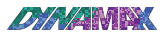

In [112]:
# Plot the mask on top of rectanges
fig = plt.figure(figsize=FIGSIZE_PX / DPI)
ax = fig.add_axes((0, 0, 1, 1))
ax.patch.set_color('w')

for rect in patches:
    ax.add_patch(rect)

# overlay the mask
mask = plt.imread("mask.png")
ax.imshow(mask, aspect="auto", zorder=1000)

# remove the axes and spines
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for sp in ax.spines.values():
    sp.set_visible(False)

ax.set_xlim(0, FIGSIZE_PX[0])
ax.set_ylim(FIGSIZE_PX[1], 0)

plt.savefig("logo-000.png", dpi=250)

for t in progress_bar(range(1, num_timesteps)):
    for rect, color in zip(patches, colors[t]):
        rect.set_facecolor(COLORS[color])
    plt.savefig("logo-{:03d}.png".format(t), dpi=250)
    
# Save a high resolution static logo
plt.savefig("logo.png".format(t), dpi=1000)

In [114]:
!convert -delay 50 -loop 0 `ls -v logo-*.png` logo.gif

In [ ]:
!rm logo-*.png